In [1]:
# インポート
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from keras.datasets import mnist

/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kou

# ディープニューラルネットワークスクラッチ

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

### 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


手を加える箇所


層の数
層の種類（今後畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

### 《サンプルコード1》


ScratchDeepNeuralNetrowkClassifierのfitメソッド内



```
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数
optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

### 《サンプルコード2》


イテレーションごとのフォワード



```
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

### 《サンプルコード3》


イテレーションごとのバックワード

```
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```

# 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

### 《雛形》

In [146]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, lr, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer(lr)
        self.initializer = initializer()
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        pass
        # 更新
        batch_size = dA.shape[0]
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.dB = np.sum(dA, axis=0, keepdims=True)[0]
        dZ = np.dot(dA, self.W.T) 
        self.optimizer.update(self)
        return dZ

In [140]:
tmp = FC(lr=0.01, n_nodes1=784, n_nodes2=400, initializer=HeInitializer, optimizer=AdaGrad)

In [141]:
tmp.forward(X_train[100:120])

array([[-0.19165627, -0.00174032, -0.35767651, ..., -0.12533766,
         0.02016278, -0.48636624],
       [ 0.61738534,  0.21311891,  0.24371706, ...,  0.32981892,
        -0.14100436, -0.46085382],
       [ 0.72354571,  0.13904864,  0.08141931, ..., -0.07824193,
         0.09635788, -0.66528307],
       ...,
       [ 0.45502782, -0.02487044, -0.00229433, ...,  0.41732181,
         0.3791583 , -0.37315155],
       [ 0.07655439, -0.00428627,  0.30158949, ..., -0.22494649,
        -0.56595782, -0.39354185],
       [ 0.19900252, -0.17529759, -0.14717502, ..., -0.43370845,
        -0.06073787, -0.34110054]])

In [3]:
def visualize(xs, ys):
    plt.figure()
    plt.plot(xs, ys, marker='.')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):# インスタンス変数の初期化
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:# hがなければ、辞書型を代入する。
            self.h = {}
            for key, val in params.items():# itemsで、keyとvalueをゲットする。
                self.h[key] = np.zeros_like(val) # それぞれkeyに対応した値を代入する。
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]#h <- h + ∂L/∂W ⊙ ∂L/∂W に対応するところ
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)#  W <- W - η *(1/√h)* ∂L/∂W に対応するところ。
            # 最後の1e-7は、self.h[key]の中に０があった場合に、０で除算してしまうことを防ぐためのもの。
            # ディープラーニングのフレームワークではこの小さな値もパラメータとして設定できるようになっている。

# 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。


### 《雛形》

In [5]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = sigma * np.random.randn( n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = sigma * np.random.randn(n_nodes2)
        return B

# 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。


### 《雛形》

In [6]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW


# 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [7]:
class Sigmoid:
    def __init__(self):
        self.y = None
    
    def forward(self, A):
        self.y = 1 / (1 + np.exp(-np.clip(A, -250, 250))) 
        return self.y
    
    def backward(self, dout):
        dz = dout * (1 - self.y) * self.y
        return dz

In [8]:
class Tanh:
    def __init__(self):
        self.y = None
    
    def forward(self, A):
        self.y = np.tanh(A) 
        return self.y
    
    def backward(self, dout):
        dz = dout * (1 - self.y**2)
        return dz

In [150]:
class Softmax:
    def __init__(self, loss_func="cel"):
        self.loss = None
        self.y = None

    
    def forward(self, A):
        maxA = np.max(A, axis=1).reshape(-1,1)
        frac1 = np.exp(A-maxA)
        frac2 = np.sum(frac1, axis=1,  keepdims=True)
        self.y = frac1 / frac2
        return self.y
    
    
    def backward(self, z, t):
        self.loss = self._cross_entropy_loss(z, t)
        y = z - t
        #print(y[0])
        #print(y.shape)
        return y
    
        
    def _cross_entropy_loss(self, z, t):
        if t.ndim == 1:
            z = z.reshape(1, z.size)
            t = t.reshape(1, t.size)

        batch_size = z.shape[0]
        loss = -np.sum(t * np.log(z + 1e-9)) / batch_size
        return loss

In [10]:
class cel():
    def cross_entropy_loss(self, y, t):
        if y.ndim == 1:
            t = t.reshape(1, t.size)
            y = y.reshape(1, y.size)

        batch_size = t.shape[0]
        loss = -np.sum(y * np.log(t + 1e-9)) / batch_size
        return loss

### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。


# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
f(x)=ReLU(x)={xif x>0,0if x≦0.
$$

$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
∂f(x)∂x={1if x>0,0if x≦0.
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [81]:
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        y = x.copy()
        y[self.mask] = 0
        return y
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx


# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。


### Xavierの初期値
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma=1\sqrt{n}
$$

$n$ : 前の層のノード数


《論文》


[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)


### Heの初期値
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma=\sqrt{\frac{1}{2n}}
$$

$n$ : 前の層のノード数


《論文》


[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [12]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = sigma * np.random.randn( n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

In [13]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(1/n_nodes1)
        W = sigma * np.random.randn( n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

# 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。


$$
W^′_i=W_i - \alpha E(\partial L \partial W_i)
$$
$$
B^′_i=B_i - \alpha E(\partial L \partial B_i)
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。


$$
H^′_i=H_i + E(\frac{\partial L}{ \partial W_i}) * E(\frac{\partial L} {\partial Wi})
$$
$$
W^′_i=W_i - \alpha \frac{1}{\sqrt{H^′_i}}E(\frac{\partial L}{\partial W_i})
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$


《論文》


[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)



In [97]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.hw = None
        self.hb = None
        
    def update(self, layer):
        if self.hw is None and self.hb is None :
            self.hw = 0
            self.hb = 0
            
        self.hw += np.sum(layer.dW ** 2)
        self.hb += np.sum(layer.dB ** 2)
        layer.W -= self.lr * layer.dW / (np.sqrt(self.hw) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.hb) + 1e-7)
        

# 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。



### 【データ作成】

In [22]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [23]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


In [24]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [25]:
X_train.shape

(60000, 784)

In [26]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
print(X_train[0].dtype) 

1.0
0.0
float64


In [27]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [29]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [305]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
#print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    
    pass

### 【解答】自作関数

In [226]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    DNNを行うクラス
    paramater
    ---------------------------------
    self.lr : 学習率 
    
    
    """
    
    def __init__(self, lr, batch_size=20, verbose=True):
        """
        initializer = "XavierInitializer", "HeInitializer"
        optimizer = "SGD", "AdaGrad"
        """
        self.lr = lr
        self.batch_size = batch_size
        self.verbose = verbose
    
    def _one_hot(self, y):
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        return y_one_hot
    
    def fit(self, X, y, epoch=3, n_nodes_1=400, n_nodes_2=200, activation=Sigmoid, Initializer=HeInitializer, optimizer=AdaGrad):
        """
        activation : "Sigmoid", "Tanh"
        """
        self.loss_dict = {}
        self.n_nodes_1 = n_nodes_1
        self.n_nodes_2 = n_nodes_2
        
        if y.ndim == 1:
            y = self._one_hot(y)
        
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]
        
        self.FC1 = FC(self.lr, self.n_features, self.n_nodes_1, Initializer, optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.lr, self.n_nodes_1, self.n_nodes_2,  Initializer, optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.lr, self.n_nodes_2, self.n_output,  Initializer, optimizer)
        self.activation3 = Softmax()
        
        cnt = 1
        for i in range(epoch):
            # ミニバッチインスタンス
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            # ミニバッチ開始、バッチサイズ20
            #print(self.FC2.W)
            for mini_X_train, mini_y_train in get_mini_batch:
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                Loss Curvを描くための処理
                """
                self.loss_dict[cnt] = self.activation3._cross_entropy_loss(Z3, mini_y_train)
                #print(self.loss_dict)
                

                dA3 = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                #print("batch_{} : loss : {}".format(cnt, self.loss_dict[cnt]))
                
                cnt += 1
            
            
            #epoch_pred = self.predict(X)
            #epoch_acc = ((np.sum(y == epoch_pred)).astype(np.float) / X.shape[0])
            
            print("-------------------------------------------")
            #print("epoch_{} // acc : {}".format(i, epoch_acc))
            print("epoch_{} // loss : {}".format(i, self.loss_dict[cnt - get_mini_batch._stop]))
            #print(self.loss_dict)

        #return self.loss_dict
            
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        return np.argmax(y, axis=1)
    
#    def plot_loss(self,loss_dict):
        

In [242]:
tmp = ScratchDeepNeuralNetrowkClassifier(0.1, batch_size=20, verbose=True)

In [246]:
%%timeit -r 1 -n 1
tmp.fit(X_train, y_train,epoch=100)

-------------------------------------------
epoch_0 // loss : 2.2475931400692533
-------------------------------------------
epoch_1 // loss : 0.36399550129671826
-------------------------------------------
epoch_2 // loss : 0.3089587876179551
-------------------------------------------
epoch_3 // loss : 0.2801598378404234
-------------------------------------------
epoch_4 // loss : 0.2604301485523818
-------------------------------------------
epoch_5 // loss : 0.24556356363081516
-------------------------------------------
epoch_6 // loss : 0.23344655355799535
-------------------------------------------
epoch_7 // loss : 0.22336406169539308
-------------------------------------------
epoch_8 // loss : 0.21496132041479815
-------------------------------------------
epoch_9 // loss : 0.20770544628169496
-------------------------------------------
epoch_10 // loss : 0.2013793896767043
-------------------------------------------
epoch_11 // loss : 0.19591486280706646
-------------------

In [272]:
pred = tmp.predict(X_test)
pred[0:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [273]:
y_test[0:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=uint8)

In [274]:
acc2 = ((np.sum(y_test == pred)).astype(np.float) / X_test.shape[0])
acc2

0.9462

# 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

### 【解答】tanh版

In [287]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    DNNを行うクラス
    paramater
    ---------------------------------
    self.lr : 学習率 
    
    
    """
    
    def __init__(self, lr, batch_size=20, verbose=True):
        """
        initializer = "XavierInitializer", "HeInitializer"
        optimizer = "SGD", "AdaGrad"
        """
        self.lr = lr
        self.batch_size = batch_size
        self.verbose = verbose
    
    def _one_hot(self, y):
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        return y_one_hot
    
    def fit(self, X, y, epoch=10, n_nodes_1=400, n_nodes_2=200, activation=Tanh, Initializer=HeInitializer, optimizer=AdaGrad):
        """
        activation : "Sigmoid", "Tanh"
        """
        self.loss_dict = {}
        self.n_nodes_1 = n_nodes_1
        self.n_nodes_2 = n_nodes_2
        
        if y.ndim == 1:
            y = self._one_hot(y)
        
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]
        
        self.FC1 = FC(self.lr, self.n_features, self.n_nodes_1, Initializer, optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.lr, self.n_nodes_1, self.n_nodes_2,  Initializer, optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.lr, self.n_nodes_2, self.n_output,  Initializer, optimizer)
        self.activation3 = Softmax()
        
        cnt = 1
        for i in range(epoch):
            # ミニバッチインスタンス
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            # ミニバッチ開始、バッチサイズ20
            #print(self.FC2.W)
            for mini_X_train, mini_y_train in get_mini_batch:
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                Loss Curvを描くための処理
                """
                self.loss_dict[cnt] = self.activation3._cross_entropy_loss(Z3, mini_y_train)
                #print(self.loss_dict)
                

                dA3 = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                #print("batch_{} : loss : {}".format(cnt, self.loss_dict[cnt]))
                
                cnt += 1
            
            
            #epoch_pred = self.predict(X)
            #epoch_acc = ((np.sum(y == epoch_pred)).astype(np.float) / X.shape[0])
            
            print("-------------------------------------------")
            #print("epoch_{} // acc : {}".format(i, epoch_acc))
            print("epoch_{} // loss : {}".format(i, self.loss_dict[cnt - get_mini_batch._stop]))
            #print(self.loss_dict)

        #return self.loss_dict
            
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        return np.argmax(y, axis=1)
    
#    def plot_loss(self,loss_dict):
        

In [288]:
q9_test = ScratchDeepNeuralNetrowkClassifier(0.1, batch_size=20, verbose=True)

In [289]:
%%timeit -r 1 -n 1
q9_test.fit(X_train, y_train,epoch=100)

-------------------------------------------
epoch_0 // loss : 2.359404200715454
-------------------------------------------
epoch_1 // loss : 0.29868154381402645
-------------------------------------------
epoch_2 // loss : 0.2384823113033116
-------------------------------------------
epoch_3 // loss : 0.20888777443203552
-------------------------------------------
epoch_4 // loss : 0.19058787408956226
-------------------------------------------
epoch_5 // loss : 0.1779238551686208
-------------------------------------------
epoch_6 // loss : 0.16851501016059967
-------------------------------------------
epoch_7 // loss : 0.16117211646934443
-------------------------------------------
epoch_8 // loss : 0.1552322768736678
-------------------------------------------
epoch_9 // loss : 0.15029533438333284
-------------------------------------------
epoch_10 // loss : 0.14610440054635682
-------------------------------------------
epoch_11 // loss : 0.14248625535309378
-------------------

-------------------------------------------
epoch_99 // loss : 0.08576551826219944
17min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [306]:
plot_list = []
for i in range(1,24000,2400):
    plot_list.append(q9_test.loss_dict[i])

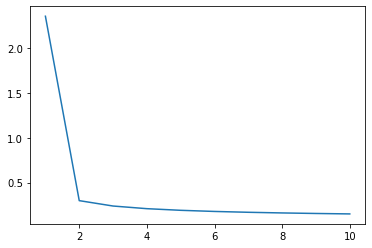

In [307]:
plt.plot(np.arange(1,11), plot_list)
plt.show()

In [309]:
tanh_pred = q9_test.predict(X_test)
tanh_pred

array([7, 2, 1, ..., 4, 5, 6])

In [310]:
print("\n Accuracy: {}".format(accuracy_score(y_test, tanh_pred)))


 Accuracy: 0.9366


シグモイド関数よりも若干下がった